In [14]:
from google.colab import files, auth, drive
from urllib.request import urlopen
from typing import List, Dict, Callable
from collections import Counter
from os import path
import numpy as np
import torch
from torch import nn
from torch.optim import SGD, Adam
from matplotlib import pyplot as plt
import glob
import unicodedata
import string


############################## CONSTANTS #######################################
def findFiles(path): return glob.glob(path)

ROOT_COLAB_FOLDER = "/content"
filename = "*.txt" #modify filename here
filepath = path.join(ROOT_COLAB_FOLDER, filename)

print(findFiles(filepath))

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]
  
for filename in findFiles(filepath):
    category = filename[len(ROOT_COLAB_FOLDER) + 1:filename.find('.txt')]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['/content/German.txt', '/content/Greek.txt', '/content/Korean.txt', '/content/Dutch.txt', '/content/Italian.txt', '/content/Russian.txt', '/content/Czech.txt', '/content/Irish.txt', '/content/Japanese.txt', '/content/Portuguese.txt', '/content/Polish.txt', '/content/English.txt', '/content/Arabic.txt', '/content/Spanish.txt', '/content/Vietnamese.txt', '/content/Scottish.txt', '/content/French.txt', '/content/Chinese.txt']
Slusarski


In [15]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [16]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [0]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [0]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [19]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9021, -2.8407, -2.8834, -2.9378, -2.7823, -3.0048, -2.9341, -2.9694,
         -2.9342, -2.8103, -2.8853, -2.9427, -2.7704, -2.9950, -2.9788, -2.9512,
         -2.7844, -2.7753]], grad_fn=<LogSoftmaxBackward>)


In [20]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Arabic', 12)


In [21]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Czech / line = Pinter
category = Polish / line = Bernard
category = French / line = Pan
category = Vietnamese / line = Mai
category = Korean / line = Kim
category = Italian / line = Roma
category = Vietnamese / line = Doan
category = Polish / line = Jelen
category = Portuguese / line = Silva
category = Italian / line = Tafani


In [0]:
criterion = nn.NLLLoss()

In [0]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [29]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 8s) 0.0681 Kedzierski / Polish ✓
10000 10% (0m 17s) 1.9821 Santana / Portuguese ✗ (Spanish)
15000 15% (0m 26s) 0.1964 Stamatas / Greek ✓
20000 20% (0m 34s) 3.3943 Dahl / Vietnamese ✗ (German)
25000 25% (0m 41s) 0.1071 Mckenzie / Scottish ✓
30000 30% (0m 51s) 1.2809 Santos / Portuguese ✓
35000 35% (1m 0s) 1.4974 Gouveia / Spanish ✗ (Portuguese)
40000 40% (1m 9s) 2.4921 Almasi / Italian ✗ (Arabic)
45000 45% (1m 17s) 1.7385 Sachs / Portuguese ✗ (German)
50000 50% (1m 25s) 0.3620 Chikhanchin / Russian ✓
55000 55% (1m 34s) 3.4471 Gravari / Portuguese ✗ (Greek)
60000 60% (1m 40s) 2.3284 Sullivan / English ✗ (Irish)
65000 65% (1m 45s) 2.0317 Adam / Arabic ✗ (Irish)
70000 70% (1m 50s) 1.1227 Basara / Japanese ✗ (Arabic)
75000 75% (1m 57s) 1.8330 Fraser / German ✗ (Scottish)
80000 80% (2m 7s) 1.0039 Maria / Spanish ✗ (Portuguese)
85000 85% (2m 16s) 2.0987 Honda / Czech ✗ (Japanese)
90000 90% (2m 25s) 0.6917 Rebka / Czech ✓
95000 95% (2m 33s) 1.6718 Sung / Chinese ✗ (Korean)
100000 1

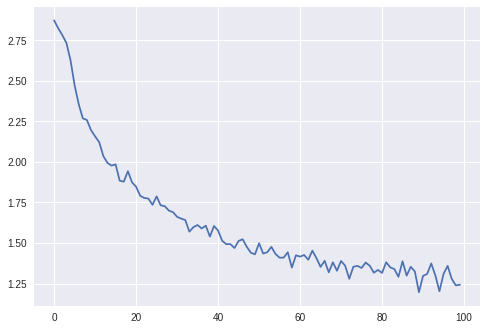

In [25]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

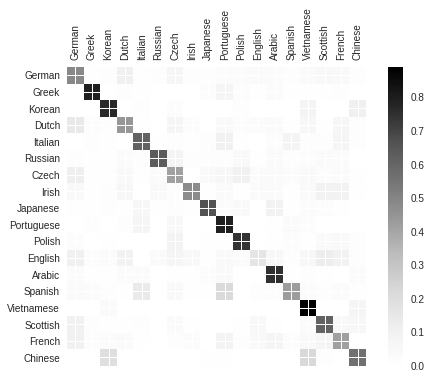

In [26]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [27]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.47) Czech
(-1.22) Russian
(-3.19) English

> Jackson
(-1.07) Scottish
(-1.59) English
(-1.67) Russian

> Satoshi
(-0.62) Arabic
(-1.93) Japanese
(-2.11) Italian
